Dorrit0, dorrit1, jelle0, night0, night1

In [5]:
data_path_old = r"C:\Users\Fin Amin\Desktop/\StemCellResearch\datasets_Sahil_preprocessed_final-20220525T021621Z-001\datasets_Sahil_preprocessed_final\exp1"
matrix_path = "regulator-gene-matrix.csv"
data_path_syn = r"C:\Users\Fin Amin\Desktop\StemCellResearch\Fin_preProcessed\synData"
data_path_inter =  r"C:\Users\Fin Amin\Desktop\StemCellResearch\Fin_preProcessed\interpolatedOnly"
data_path_og_exp1 = r"C:\Users\Fin Amin\Desktop\StemCellResearch\Fin_preProcessed\datasets\exp1"
data_path_testSet = r"C:\Users\Fin Amin\Desktop\StemCellResearch\testSetFixed"
data_path_petal = r"C:\Users\Fin Amin\Desktop\StemCellResearch\petal_len.xlsx"

In [6]:
#!pip3 install keras-visualizer
#!pip install pydot
#data_path_og_exp1 = data_path_testSet 
# !pip install pydot
# !pip install pydotplus
# !pip install graphviz

In [ ]:
import tensorflow as tf
from tensorflow import keras
from datetime import datetime
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from keras_visualizer import visualizer 

from tensorflow.keras.layers import*
import shap
from keras.utils.vis_utils import plot_model
# from keras.layers import Input
# from keras.layers import Dense
# from keras.layers import Conv1D
# from keras.layers import Conv1DTranspose
# from keras.layers import Flatten, Reshape

import os
from glob import glob
from tqdm import tqdm
from tensorflow.keras import losses
from sklearn.preprocessing import StandardScaler
from sklearn.preprocessing import MinMaxScaler
#import tensorboard

In [ ]:
tf.config.list_physical_devices(
    device_type=None
)
tf.config.list_physical_devices('GPU')

[PhysicalDevice(name='/physical_device:GPU:0', device_type='GPU')]

In [ ]:
gpus = tf.config.list_physical_devices('GPU')
if gpus:
  try:
    # Currently, memory growth needs to be the same across GPUs
    for gpu in gpus:
      tf.config.experimental.set_memory_growth(gpu, True)
    logical_gpus = tf.config.list_logical_devices('GPU')
    print(len(gpus), "Physical GPUs,", len(logical_gpus), "Logical GPUs")
  except RuntimeError as e:
    # Memory growth must be set before GPUs have been initialized
    print(e)

1 Physical GPUs, 1 Logical GPUs


In [ ]:
tf.executing_eagerly()

True

In [ ]:
NUM_PARENTS = 21
NUM_TARGETS = 245

In [ ]:
# logdir="logs/fit/" + datetime.now().strftime("%Y%m%d-%H%M%S")
# tensorboard_callback = keras.callbacks.TensorBoard(log_dir=logdir)

In [ ]:
import warnings
warnings.filterwarnings('ignore')

In [ ]:
import matplotlib.pylab as pylab
params = {'legend.fontsize': 'x-large',
          'figure.figsize': (15, 5),
         'axes.labelsize': 'x-large',
         'axes.titlesize':'x-large',
         'xtick.labelsize':'x-large',
         'ytick.labelsize':'x-large'}
pylab.rcParams.update(params)

# Load the test set and the synthetic dataset:


In [ ]:
def loadTestSet(test_path):
    testFiles = []
    for np_name in glob(os.path.join(data_path_testSet,'*.np[yz]')):
        k = np.load(os.path.join(data_path_testSet,np_name))
        testFiles.append(k)
#         print(np_name)
#         print(k.shape)
    return np.array(testFiles)

In [ ]:
test = loadTestSet(data_path_testSet)
testCandidate = test.astype(np.float)


In [ ]:
def read_files(data_path):

    #genes_intensities_data_matrix = pd.read_csv(file_path_intensities, index_col = 0)
    #print(os.listdir(data_path))
    replicate_files = os.listdir(data_path)
    #print('replicate files:',replicate_files)
    replicates = []
    # i = 0
    for file in replicate_files:
        
        try:
            #print('file name:',file)
            #print('value of i:',i)
            genes_intensities_data_matrix = pd.read_csv(os.path.join(data_path , file), index_col = 0, on_bad_lines='skip')
            #print('genes_intensities_data_matrix:',  genes_intensities_data_matrix.head())
            replicates.append(np.array(genes_intensities_data_matrix.values, dtype = float))
            # i+=1
        except PermissionError:
            print("Not a CSV: ", os.path.join(data_path , file))
        
    genes_intensities_data_matrix = genes_intensities_data_matrix.values
    rgm = np.loadtxt(matrix_path)
    rep = np.array(replicates).astype(np.float32)
    
    return rep, rgm.astype(np.float32)

In [ ]:
genes_intensities_normalized, regulator_gene_matrix= read_files(data_path_syn)
matrix = regulator_gene_matrix
replicates = genes_intensities_normalized

In [ ]:
matrix.shape

(245, 245)

In [ ]:
replicates.shape

(6, 6, 245)

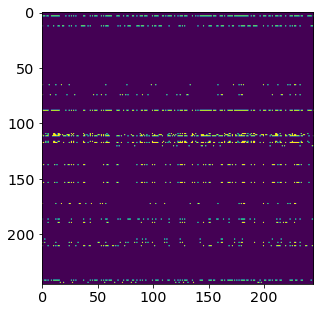

In [ ]:
plt.imshow(matrix)

In [ ]:
#%tensorflow_version 2.x
device_name = tf.test.gpu_device_name()
if device_name != '/device:GPU:0':
  raise SystemError('GPU device not found')
print('Found GPU at: {}'.format(device_name))

Found GPU at: /device:GPU:0


# Ordinary Auto Encoder

In [ ]:
class EncoderLinear(tf.keras.layers.Layer):
    def __init__(self, rgm, input_dim=32, units=32):
        super(EncoderLinear, self).__init__()
        self.rgm = rgm
        
        def init_weights(shape, dtype="float32"):

            w_init = tf.random_normal_initializer()(shape=shape, dtype=dtype) * tf.convert_to_tensor(self.rgm, dtype=dtype)

            return w_init
        

        self.w = tf.Variable(
            initial_value=init_weights(shape=(input_dim, units), dtype="float32"),
            trainable=True,
        )

    def call(self, inputs):
        X = inputs
        return tf.matmul(X, tf.multiply(self.rgm, self.w))
    #tf.matmul(inputs, self.w)

In [ ]:
class DecoderLinear(tf.keras.layers.Layer):
    def __init__(self, rgm, input_dim=32, units=32):
        super(DecoderLinear, self).__init__()
        self.rgm = rgm

        def init_weights(shape, dtype="float32"):

            w_init = tf.random_normal_initializer()(shape=shape, dtype=dtype) * tf.transpose(tf.convert_to_tensor(self.rgm, dtype=dtype))

            return w_init
    
        
        self.w = tf.Variable(
            initial_value=init_weights(shape=(input_dim, units), dtype="float32"),
            trainable=True,
        )

    def call(self, inputs):
        X = inputs
        #return tf.matmul(X, tf.multiply((self.rgm), self.w))
        X = tf.matmul(X, tf.multiply(tf.transpose(self.rgm), self.w)) 
        #return tf.matmul(inputs, self.w)
        # v = tf.zeros_like(X)
        # u = tf.ones_like(X)
        # u = tf.math.scalar_mul(-3.0, u)
        
        return X#tf.where(tf.math.less(X, v), u, X) #where X is less than 0, return -1 
        
        

In [ ]:
def encoder(parent_child_biological_association, num_hidden_units=21):
    '''
    Encoder structure
    '''
    '''
    The data is time-series. Therefore, CNN to learn the temporal relationship between 
    the intensities for each gene.
    '''
    en_conv = Conv1D(490, 3, activation = "relu")(parent_child_biological_association) # 6*245 Conv1D(32, 3, activation = "relu")(parent_child_biological_association)
    en_dense = Flatten()(en_conv)
    phenotype = Dense(num_hidden_units)(en_dense)
    return phenotype

def decoder(X, num_protein_gene, time_steps):
    '''
    Decoder structure
    '''
    de_dense = Dense(1024)(X)#Dense(128)(X)
    de_dense = Reshape((1, 1024))(de_dense) #tf.reshape(de_dense, (self.batch_size,1,128))
    de_deconv = Conv1DTranspose(num_protein_gene, time_steps, activation = "relu")(de_dense) #used to be transpose
    #de_deconv = Conv1D(num_protein_gene, time_steps, activation = "relu")(de_dense) 
    # gene_reconstruction = self.decoder_biological_operation(de_deconv)
    return de_deconv

def model(rgm, num_protein_gene, time_steps, num_kinase_regulators, num_hidden_units = 21):
    inp = Input(shape=(time_steps, num_kinase_regulators))
    x = EncoderLinear(rgm, 245, 245)(inp)
    enc = encoder(x, num_hidden_units)
    dec = decoder(enc, num_protein_gene, time_steps)
    out = DecoderLinear(rgm, 245, 245)(dec)

    _model = tf.keras.Model(inputs=inp, outputs=out)

    return _model

In [ ]:
regulator_gene_matrix = matrix# np.random.randint(0, 2, size=(245, 245)).astype(np.float32)


In [ ]:
enc_dec_Synthetic = model(regulator_gene_matrix, 245, 6, 245) #we can just change the time steps to something higher

In [ ]:
enc_dec_Synthetic.summary()

Model: "model"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_1 (InputLayer)        [(None, 6, 245)]          0         
                                                                 
 encoder_linear (EncoderLine  (None, 6, 245)           60025     
 ar)                                                             
                                                                 
 conv1d (Conv1D)             (None, 4, 490)            360640    
                                                                 
 flatten (Flatten)           (None, 1960)              0         
                                                                 
 dense (Dense)               (None, 21)                41181     
                                                                 
 dense_1 (Dense)             (None, 1024)              22528     
                                                             

In [ ]:
type(enc_dec_Synthetic)

keras.engine.functional.Functional

In [ ]:
a = [1,2,3]
b = [5,6]
u = tf.concat([a,b], axis = 0)
u

<tf.Tensor: shape=(5,), dtype=int32, numpy=array([1, 2, 3, 5, 6])>

# Super Parent Matrix + Custom Loss
FOR USE LATER!!

In [ ]:
superParent = regulator_gene_matrix.copy() #init the super parent with the ordinary RGM, and do forward passes with super parent
#print(superParent.shape)

ones = np.ones((245))
parentIndex = []
not_parentIndex = []
for i in range(len(regulator_gene_matrix)):
    if (np.isin(regulator_gene_matrix[i], [1])).any():
        #print(i)
        superParent[i] = ones 
        parentIndex.append(i)
    else:
        not_parentIndex.append(i)

parentIndex = np.array(parentIndex)
parentIndex = tf.convert_to_tensor(parentIndex)
not_parentIndex = np.array(not_parentIndex)
not_parentIndex = tf.convert_to_tensor(not_parentIndex)
print("shape of parent index", parentIndex.shape)

def ignore_noParent_MSE_old(y_true, y_pred): 
    l = tf.keras.losses.MeanSquaredError()
    y_true_pruned = tf.gather(y_true,parentIndex, axis =2)
    #print(y_true_pruned.shape
    y_pred_pruned = tf.gather(y_pred, parentIndex, axis =2)   
    return l(y_true_pruned, y_pred_pruned)

def ignore_noParent_MSE(y_true, y_pred): 
    l = tf.keras.losses.MeanSquaredError()

    y_true_pruned = tf.gather(y_true, parentIndex, axis = 2)
    #print(y_true_pruned)
    y_true_pruned = tf.reshape(y_true_pruned, shape=([tf.size(y_true_pruned)] ) )
    y_pred_pruned = tf.gather(y_pred, parentIndex, axis = 2) 
    y_pred_pruned = tf.reshape(y_pred_pruned, shape=([tf.size(y_pred_pruned)]) )

    y_true_posID = tf.where(y_true_pruned >= 0) #gets args
    y_true_posID = tf.squeeze(y_true_posID)

    y_true_negID = tf.where(y_true_pruned < 0) #get the idx of all the -1s in y_true
    y_true_negID = tf.squeeze(y_true_negID)
    y_true_neg = tf.gather(y_true_pruned, y_true_negID) #get all the -1s in y_true
    y_pred_neg = tf.gather(y_pred_pruned, y_true_negID) #get the corresponding values for y_pred

    y_shouldBeNegButIsntID = tf.where(y_pred_neg >= 0)  
    y_shouldBeNegButIsntID = tf.squeeze(y_shouldBeNegButIsntID) #get the idx which should be -1 for prediction but are not
    y_true_wrong = tf.gather(y_true_pruned, y_shouldBeNegButIsntID) #get the same corresponding values from ypred
    y_shouldBeNegButIsnt = tf.gather(y_pred_pruned, y_shouldBeNegButIsntID) #this has all the wrongly predicted values which should be -1 but are not

    y_true_pos = tf.gather(y_true_pruned, y_true_posID)
    y_pred_pos = tf.gather(y_pred_pruned, y_true_posID)

    if tf.size(y_shouldBeNegButIsnt) == 0: #we can not concatenate if the size is 0. 
        return l(y_true_pos, y_pred_pos)

    y_pred_total = tf.concat([y_pred_pos, y_shouldBeNegButIsnt], axis = 0) #concatenate for total mse
    y_true_total = tf.concat([y_true_pos, y_true_wrong], axis = 0)

    return l(y_true_total, y_pred_total)

shape of parent index (21,)


In [ ]:
newConnections = superParent - regulator_gene_matrix

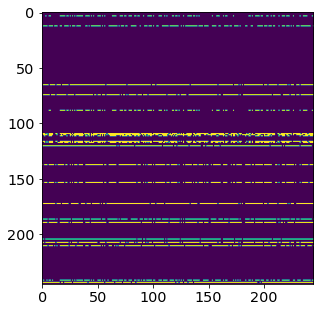

In [ ]:
plt.imshow(newConnections)

In [ ]:
nC = []
for i in range(len(newConnections[0])):
    for j in range(len(newConnections[1])):
        if newConnections[i][j] > 0:
            nC.append([i,j])
nC = np.array(nC)
nC = pd.DataFrame(nC)
nC.to_csv("new_connections_in_superParents.csv")

In [ ]:
###Code for testing loss function
# print(outSyn.shape)
# print(testCandidate.shape)
# syntheticLoss = ignore_noParent_MSE(np.array([testCandidate[0]]), np.array([outSyn[0]]) )
# syntheticLoss

# Synthetic Dataset Auto Encoder
Autoencoder has not been trained on synthetic version of experiement 1. We test on the original experiment 1. 

In [ ]:
enc_dec_Synthetic.compile(optimizer='adam', loss=ignore_noParent_MSE)

In [ ]:
# enc_dec_Synthetic.compile(optimizer='adam',loss = keras.losses.SparseCategoricalCrossentropy(from_logits=True))

In [38]:
syntheticDataTrain = genes_intensities_normalized[1:]

In [98]:
syntheticDataTrain.shape

(5, 6, 245)

In [39]:
enc_dec_Synthetic.fit(syntheticDataTrain,syntheticDataTrain,epochs=1000)

Epoch 1/1000
1/1 [==============================] - 6s 6s/step - loss: 0.7087
Epoch 2/1000
1/1 [==============================] - 0s 7ms/step - loss: 0.7161
Epoch 3/1000
1/1 [==============================] - 0s 5ms/step - loss: 0.6750
Epoch 4/1000
1/1 [==============================] - 0s 6ms/step - loss: 0.7314
Epoch 5/1000
1/1 [==============================] - 0s 5ms/step - loss: 0.6416
Epoch 6/1000
1/1 [==============================] - 0s 6ms/step - loss: 0.5159
Epoch 7/1000
1/1 [==============================] - 0s 6ms/step - loss: 0.3971
Epoch 8/1000
1/1 [==============================] - 0s 5ms/step - loss: 0.3326
Epoch 9/1000
1/1 [==============================] - 0s 5ms/step - loss: 0.2364
Epoch 10/1000
1/1 [==============================] - 0s 5ms/step - loss: 0.1583
Epoch 11/1000
1/1 [==============================] - 0s 5ms/step - loss: 0.1389
Epoch 12/1000
1/1 [==============================] - 0s 5ms/step - loss: 0.1503
Epoch 13/1000
1/1 [==============================]

In [40]:
test = enc_dec_Synthetic(testCandidate) #, verbose = 0)
loss = ignore_noParent_MSE(testCandidate, test)
loss

<tf.Tensor: shape=(), dtype=float32, numpy=0.30834347>

In [41]:
w = enc_dec_Synthetic.get_weights()

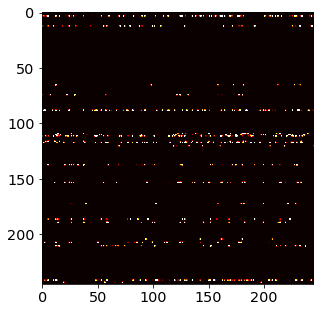

In [42]:
plt.imshow(w[0], cmap = "hot", vmin=0,vmax=0.02)

In [43]:
#we do not need to use this function for the testset
def getCSVs(data_path_head):
    PATH = data_path_head
    EXT = "*.csv"
    all_csv_files = [file
                     for path, subdir, files in os.walk(PATH)
                     for file in glob(os.path.join(path, EXT))]
    actual = []
    for p in all_csv_files:
        actual.append(pd.read_csv(p, index_col = 0).to_numpy())
    return np.array(actual)
    
experiment1 = getCSVs(data_path_og_exp1)

In [44]:
testCandidate = test.numpy().astype(np.float)

In [45]:
testCandidate.dtype

dtype('float64')

In [46]:
np.array([genes_intensities_normalized[0]]).shape

(1, 6, 245)

In [47]:
testCandidate[0].shape

(6, 245)

In [48]:
np.array([genes_intensities_normalized[0]]).shape

(1, 6, 245)

In [49]:
outSyn = enc_dec_Synthetic.predict(testCandidate)

1/1 [==============================] - 0s 140ms/step


In [50]:
def mymagn(A, B):
    mse = (np.square(A - B)).mean(axis=None)
    return mse

In [51]:
print(outSyn.shape)

(4, 6, 245)


In [52]:
syntheticLoss = ignore_noParent_MSE(testCandidate, outSyn )
syntheticLoss

<tf.Tensor: shape=(), dtype=float32, numpy=0.003503254>

In [53]:
(outSyn-testCandidate).shape

(4, 6, 245)

# Interpolated dataset Auto Encoder
Once again, we do not train on any version of exp1

In [54]:
def read_filesV2(data_path):
    '''
    *Changed*
    currently hardcoded for only one file. 
    change code a bit for reading multiple files.
    '''
    #genes_intensities_data_matrix = pd.read_csv(file_path_intensities, index_col = 0)
    #print(os.listdir(data_path))
    replicate_files = os.listdir(data_path)
    #print('replicate files:',replicate_files)
    replicates = []
    # i = 0
    for file in replicate_files:
        
        #print('file name:',file)
        #print('value of i:',i)
        genes_intensities_data_matrix = pd.read_csv(os.path.join(data_path , file), index_col = 0, on_bad_lines='skip')
        #print('genes_intensities_data_matrix:',  genes_intensities_data_matrix.head())
        replicates.append(genes_intensities_data_matrix.values)
        # i+=1
        
    genes_intensities_data_matrix = genes_intensities_data_matrix.values
    rgm = np.loadtxt(matrix_path)
    
    return np.asarray(replicates), rgm.astype(np.float32)

In [55]:
interpolated_genes, _ = read_filesV2(data_path_inter)

In [56]:
interpolated_genes.shape

(5,)

In [57]:
pd.DataFrame(interpolated_genes[2]).head(5)

,0,1,2,3,4,5,6,7,8,9,...,235,236,237,238,239,240,241,242,243,244
0,0.254943,-1.000000,0.663585,0.440312,-1.000000,0.635664,0.734571,-1.000000,0.312044,0.602692,...,-1.000000,0.400712,-1.000000,0.523033,-1.000000,0.561590,0.403879,0.642049,-1.000000,0.443478
1,0.338509,-1.000000,0.612395,0.655007,-1.000000,-1.000000,0.590564,-1.000000,0.353872,0.539972,...,-1.000000,0.445519,-1.000000,0.586067,-1.000000,0.541903,0.426403,0.495559,0.550973,0.419991
2,-1.000000,0.544463,0.596307,0.596367,-1.000000,0.629406,0.579586,0.726602,-1.000000,0.535278,...,0.509166,-1.000000,-1.000000,0.642262,-1.000000,0.586480,0.569283,-1.000000,0.596188,-1.000000
3,-0.329754,-0.454583,-0.828393,0.582746,-0.689224,0.178233,0.309607,-0.297329,-0.461788,0.493608,...,-0.024981,-0.697509,-0.153204,0.546957,0.161868,0.291320,-0.109625,-0.444279,0.007077,-0.254379
4,-1.000000,0.528085,-1.000000,0.523557,-1.000000,0.588043,0.580612,-1.000000,0.354997,0.567674,...,0.573489,0.392001,-1.000000,0.602732,-1.000000,0.544163,0.423905,-1.000000,0.578650,-1.000000


In [58]:
inter = []
for k in range(len(interpolated_genes)):
    #print(k)
    if k == 2 or k == 3 or k == 4:
        inter.append(np.reshape(interpolated_genes[k], (4,6,245)))
    else: 
        inter.append(np.reshape(interpolated_genes[k], (5,6,245)))
inter = np.vstack(inter)

In [59]:
inter.shape

(22, 6, 245)

In [60]:
genes_intensities_normalized[1:].shape

(5, 6, 245)

In [61]:
enc_dec_inter = model(regulator_gene_matrix, 245, 6, 245) 
enc_dec_inter.compile(optimizer='adam', loss=ignore_noParent_MSE)

In [62]:
enc_dec_inter.fit(inter, inter,epochs=1000);

Epoch 1/1000
1/1 [==============================] - 1s 1s/step - loss: 0.2972
Epoch 2/1000
1/1 [==============================] - 0s 7ms/step - loss: 0.3032
Epoch 3/1000
1/1 [==============================] - 0s 6ms/step - loss: 0.2890
Epoch 4/1000
1/1 [==============================] - 0s 6ms/step - loss: 0.2760
Epoch 5/1000
1/1 [==============================] - 0s 6ms/step - loss: 0.2533
Epoch 6/1000
1/1 [==============================] - 0s 5ms/step - loss: 0.2395
Epoch 7/1000
1/1 [==============================] - 0s 6ms/step - loss: 0.2286
Epoch 8/1000
1/1 [==============================] - 0s 5ms/step - loss: 0.1981
Epoch 9/1000
1/1 [==============================] - 0s 6ms/step - loss: 0.1831
Epoch 10/1000
1/1 [==============================] - 0s 6ms/step - loss: 0.1611
Epoch 11/1000
1/1 [==============================] - 0s 6ms/step - loss: 0.1743
Epoch 12/1000
1/1 [==============================] - 0s 6ms/step - loss: 0.1445
Epoch 13/1000
1/1 [==============================]

In [63]:
outInter = enc_dec_inter.predict(testCandidate)
interpolationLoss = ignore_noParent_MSE(testCandidate, outInter)

1/1 [==============================] - 0s 92ms/step


In [64]:
interpolationLoss #used to be 3.84 on broke ignore

<tf.Tensor: shape=(), dtype=float32, numpy=0.03874762>

In [65]:
outInter.shape

(4, 6, 245)

In [66]:
u = enc_dec_inter.history
u

# Comparisons between various outputs:

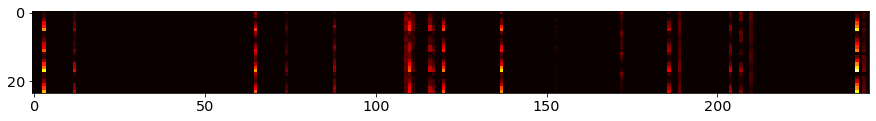

In [67]:
u = plt.imshow(np.reshape((np.abs(outSyn)), (24,245)), cmap = "hot", vmin=0,vmax=1.0 );

In [68]:
u = pd.DataFrame(outSyn[0])
u.head(10)

,0,1,2,3,4,5,6,7,8,9,...,235,236,237,238,239,240,241,242,243,244
0,0.0,0.0,0.0,-0.044796,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.046786,0.0,-0.086538,0.0
1,0.0,0.0,0.0,0.065040,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.115088,0.0,0.073042,0.0
2,0.0,0.0,0.0,0.152217,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.271785,0.0,0.033681,0.0
3,0.0,0.0,0.0,0.332588,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.461043,0.0,0.065859,0.0
4,0.0,0.0,0.0,0.393490,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.548365,0.0,0.040989,0.0
5,0.0,0.0,0.0,0.574530,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.739459,0.0,0.097823,0.0


In [69]:
u = pd.DataFrame(testCandidate[0])
u.head(10)

,0,1,2,3,4,5,6,7,8,9,...,235,236,237,238,239,240,241,242,243,244
0,0.0,0.0,0.0,-0.034413,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.109721,0.0,-0.227669,0.0
1,0.0,0.0,0.0,0.096811,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.163045,0.0,0.065389,0.0
2,0.0,0.0,0.0,0.147692,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.315729,0.0,-0.014181,0.0
3,0.0,0.0,0.0,0.359675,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.503087,0.0,0.039655,0.0
4,0.0,0.0,0.0,0.403032,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.570803,0.0,-0.041109,0.0
5,0.0,0.0,0.0,0.614099,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.793258,0.0,0.089265,0.0


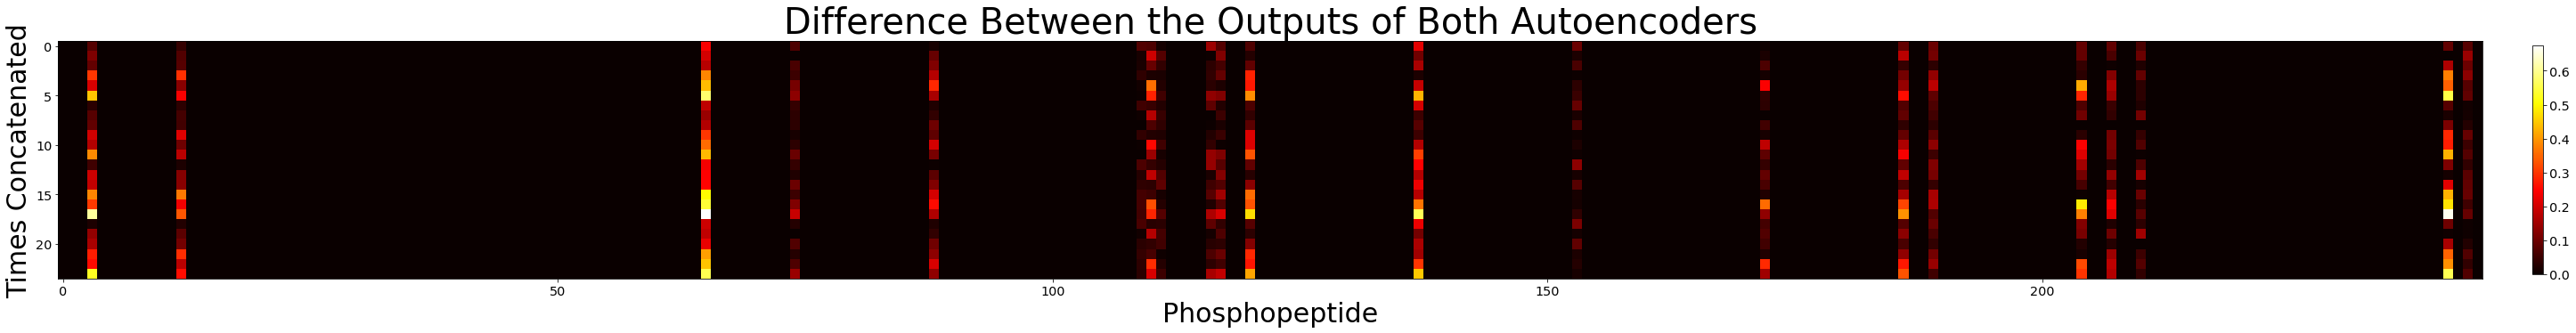

In [70]:
plt.figure(figsize=(50, 50))
u = plt.imshow(np.reshape((np.abs(outSyn-outInter)), (24,245)), cmap = "hot")#, vmin=0,vmax=1.0 );
plt.title("Difference Between the Outputs of Both Autoencoders", fontsize = 40);
plt.xlabel("Phosphopeptide", fontsize = 30);
plt.ylabel("Times Concatenated", fontsize = 30);
plt.colorbar(u ,fraction=0.0046, pad=0.02);
#plt.savefig("DiffBetweenOut.png")

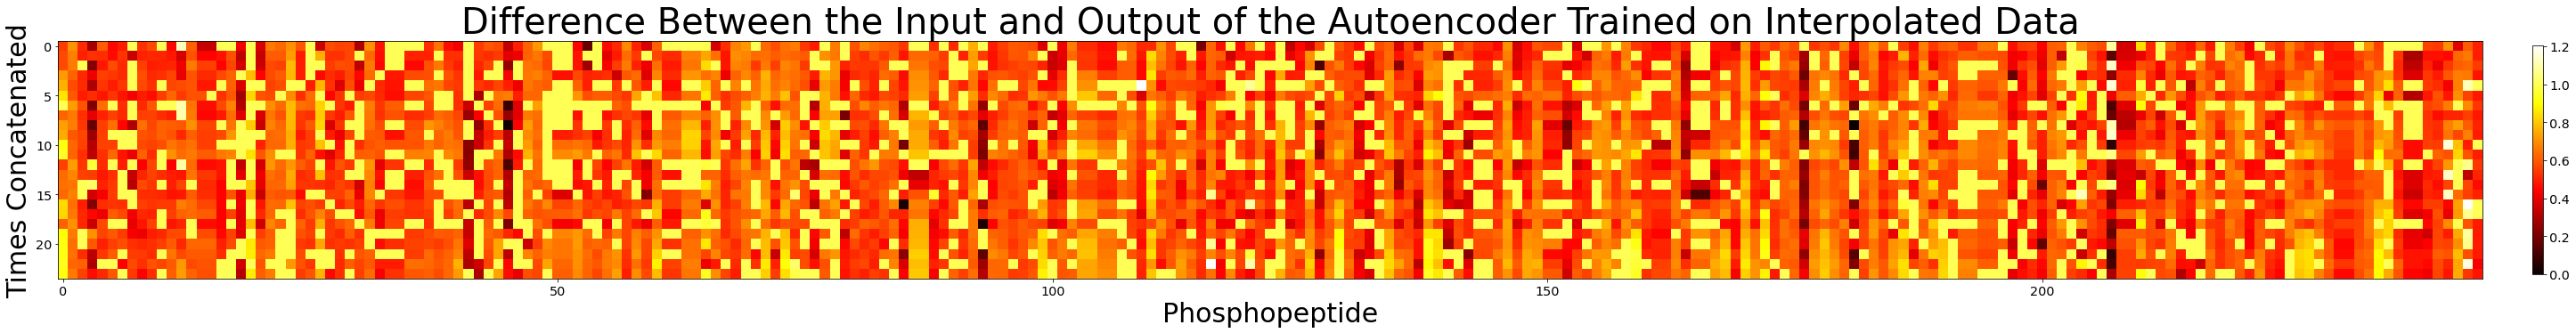

In [71]:
plt.figure(figsize=(50, 50))
u = plt.imshow(np.reshape(np.abs(outInter-experiment1), (24,245)) , cmap = "hot") #, vmin=0,vmax=1.0 )
plt.title("Difference Between the Input and Output of the Autoencoder Trained on Interpolated Data", fontsize = 40);
plt.xlabel("Phosphopeptide", fontsize = 30)
plt.ylabel("Times Concatenated", fontsize = 30);
plt.colorbar(u ,fraction=0.0046, pad=0.02);
#plt.savefig("InterDiffImage.png")

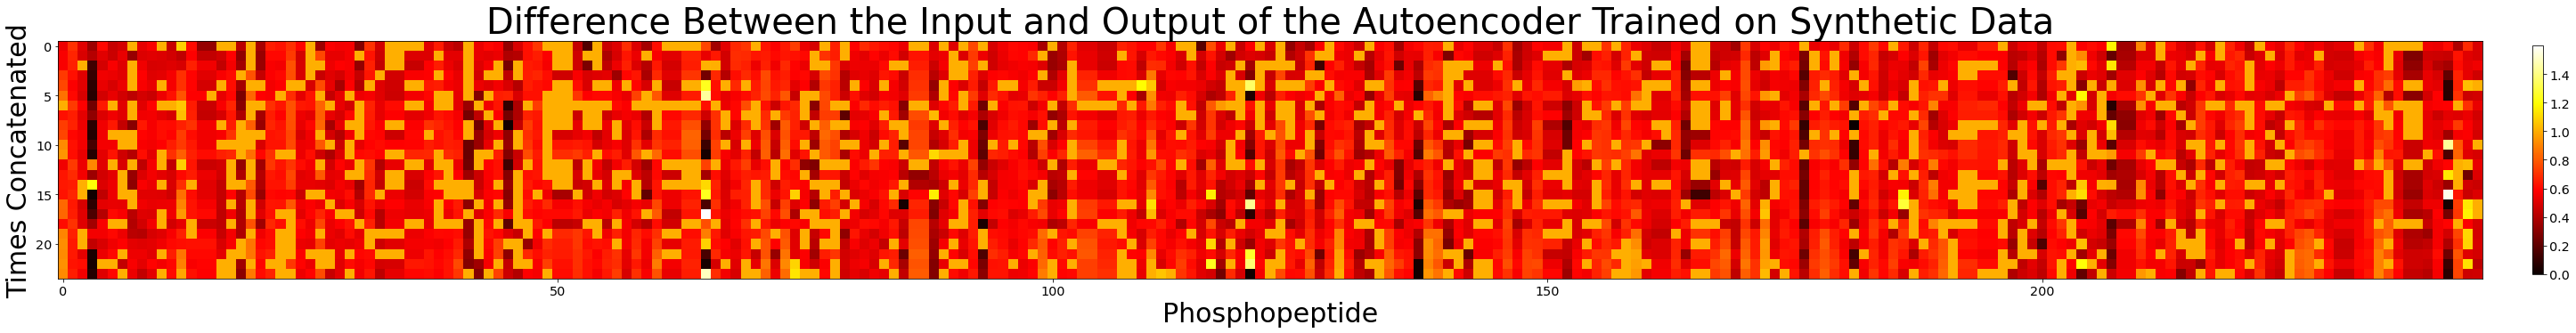

In [72]:
plt.figure(figsize=(50, 50))
u = plt.imshow(np.reshape(np.abs(outSyn-experiment1), (24,245)), cmap = "hot")#, vmin=0,vmax=1.0 )
plt.title("Difference Between the Input and Output of the Autoencoder Trained on Synthetic Data", fontsize = 40);
plt.xlabel("Phosphopeptide", fontsize = 30);
plt.ylabel("Times Concatenated", fontsize = 30);
plt.colorbar(u ,fraction=0.0046, pad=0.02);
#plt.savefig("SynDiffImage.png");

(24, 21)


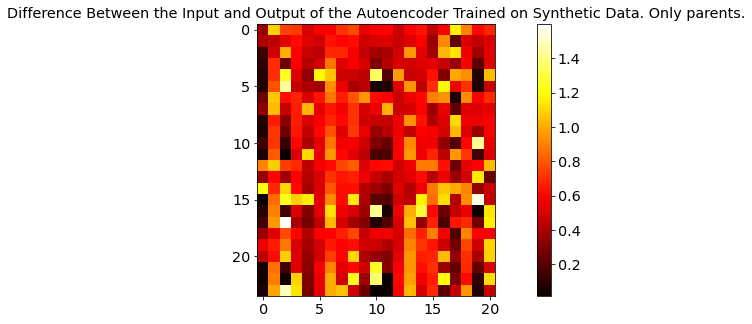

In [73]:
parent_idx = parentIndex.numpy()
#print(parent_idx)
oSyn = (np.reshape((outSyn), (24,245)).T)[parent_idx]
oSyn = oSyn.T
oSyn.shape

exp1_col = (np.reshape((experiment1), (24,245)).T)[parent_idx]
exp1_col = exp1_col.T
print(exp1_col.shape)

u = plt.imshow(np.abs(oSyn - exp1_col), cmap = 'hot') #TODO use TF loss function instead of difference.
ddff = oSyn-exp1_col
plt.colorbar(u)
plt.title("Difference Between the Input and Output of the Autoencoder Trained on Synthetic Data. Only parents.");

In [74]:
pd.DataFrame(oSyn).head(24)

,0,1,2,3,4,5,6,7,8,9,...,11,12,13,14,15,16,17,18,19,20
0,-0.044796,0.085228,-0.252574,-0.085675,0.049688,0.108898,-0.211347,0.033945,0.024141,-0.046905,...,-0.143986,0.005274,-0.153132,-0.073326,-0.128270,-0.115285,0.171615,-0.094464,0.046786,-0.086538
1,0.065040,0.065990,-0.158688,-0.019500,0.000579,0.147989,-0.105000,0.107682,0.098995,-0.028677,...,0.013437,0.006876,-0.088705,-0.004227,-0.073055,-0.084222,0.111118,-0.119473,0.115088,0.073042
2,0.152217,0.048126,0.010985,-0.013567,0.061302,0.196890,-0.154603,0.100314,0.162390,0.057274,...,0.125862,-0.036483,-0.047249,0.049340,-0.093767,0.024820,0.131280,-0.101228,0.271785,0.033681
3,0.332588,-0.119400,0.119010,0.049031,0.092714,0.138534,-0.338956,0.124615,0.156200,0.049608,...,0.146270,0.002034,-0.040178,0.145109,-0.136094,0.045132,0.035006,-0.093317,0.461043,0.065859
4,0.393490,-0.104579,0.242947,0.076527,0.205290,0.190349,-0.401654,0.146736,0.294029,0.110492,...,0.382589,-0.042936,-0.046658,0.179694,-0.123492,0.176219,-0.011811,-0.071190,0.548365,0.040989
5,0.574530,-0.194269,0.438890,0.104858,0.080759,0.167909,-0.420758,0.126809,0.280403,0.156153,...,0.495623,-0.015186,-0.051325,0.257873,-0.138757,0.184738,-0.077957,-0.087196,0.739459,0.097823
6,-0.028777,0.067057,-0.207013,-0.049554,0.053162,0.073130,-0.129289,0.041716,0.014208,-0.046893,...,-0.112589,0.008405,-0.140615,-0.050950,-0.103309,-0.063365,0.136527,-0.074866,0.046901,-0.047746
7,0.062507,0.041802,-0.124227,-0.010543,0.026975,0.103058,-0.052484,0.072653,0.069610,-0.015442,...,0.017754,0.019662,-0.096752,0.014869,-0.065631,-0.048305,0.096478,-0.086799,0.088133,0.056545
8,0.134043,0.040375,0.013473,0.004483,0.071482,0.131705,-0.093955,0.057899,0.097249,0.056862,...,0.084053,-0.019130,-0.060326,0.048413,-0.070649,0.019157,0.111879,-0.090577,0.208866,0.051063
9,0.275996,-0.079902,0.125723,0.044003,0.089330,0.075864,-0.209009,0.078592,0.080045,0.041964,...,0.125629,-0.002159,-0.081325,0.130729,-0.105777,0.048767,0.032389,-0.070640,0.365640,0.072632


In [75]:
pd.DataFrame(exp1_col).head(24)


,0,1,2,3,4,5,6,7,8,9,...,11,12,13,14,15,16,17,18,19,20
0,0.311232,-1.000000,-1.000000,0.645008,0.554178,0.690925,0.372292,0.747749,0.794170,0.495021,...,0.455733,0.472685,0.439632,0.565228,0.317936,0.461916,-1.000000,-1.000000,0.654674,0.595213
1,0.476887,0.500798,0.372761,0.601316,0.522340,0.637735,0.535247,0.707668,0.727453,0.455223,...,0.541840,0.473143,0.425360,0.582488,0.284989,-1.000000,0.331113,0.386311,0.570334,0.587421
2,0.287767,0.537002,-1.000000,0.574648,0.523913,0.632452,0.534896,0.786278,0.743514,0.512682,...,0.514102,0.454378,-1.000000,0.581471,0.285557,-1.000000,-1.000000,0.455556,0.643895,0.558828
3,0.440943,0.578982,0.374815,0.635557,0.516269,0.629227,0.533493,0.653258,0.734303,0.552866,...,0.571450,0.508228,0.451286,0.664863,0.399603,0.511530,0.391555,0.491323,0.679073,0.593245
4,0.478201,0.598115,-1.000000,0.597923,0.538137,-1.000000,0.654905,0.629435,0.768833,0.556352,...,0.571788,-1.000000,0.426957,0.674205,0.511240,0.481536,-1.000000,-1.000000,0.627382,-1.000000
5,0.647987,0.592460,-1.000000,0.558520,0.478564,0.544962,0.509113,0.680942,0.671935,0.590083,...,0.569570,0.511285,-1.000000,0.706922,0.562933,-1.000000,0.484528,0.622751,0.667441,0.564833
6,0.218619,-1.000000,0.417378,0.628405,0.564403,0.711581,-1.000000,0.702340,0.808966,-1.000000,...,0.479980,0.475295,0.408973,0.555106,-1.000000,-1.000000,0.208531,-1.000000,0.630546,0.648886
7,0.383528,-1.000000,0.349100,0.655232,-1.000000,0.645061,0.590947,0.654156,0.782149,0.489829,...,-1.000000,0.492713,0.406376,0.615306,0.299354,0.503437,0.313722,0.427484,0.611733,0.597254
8,0.213567,0.697178,0.338363,0.662920,0.580581,0.713232,0.589343,0.673497,0.808274,0.542478,...,0.542131,0.532364,-1.000000,0.689703,0.336281,0.533574,-1.000000,0.463282,0.766182,0.630140
9,0.340220,0.644924,0.387990,0.686608,0.539759,0.681096,0.577242,0.597485,0.809513,0.586733,...,0.554080,0.557906,0.370342,0.723331,0.474744,0.549192,-1.000000,0.443230,0.727473,0.650377


In [76]:
pd.DataFrame(ddff).head(24)


,0,1,2,3,4,5,6,7,8,9,...,11,12,13,14,15,16,17,18,19,20
0,-0.356028,1.085228,0.747426,-0.730683,-0.504491,-0.582027,-0.583640,-0.713804,-0.770029,-0.541926,...,-0.599719,-0.467410,-0.592764,-0.638553,-0.446206,-0.577201,1.171615,0.905536,-0.607888,-0.681751
1,-0.411846,-0.434809,-0.531449,-0.620817,-0.521761,-0.489746,-0.640247,-0.599987,-0.628459,-0.483900,...,-0.528403,-0.466267,-0.514065,-0.586716,-0.358044,0.915778,-0.219995,-0.505784,-0.455246,-0.514379
2,-0.135549,-0.488876,1.010985,-0.588215,-0.462611,-0.435562,-0.689499,-0.685964,-0.581124,-0.455408,...,-0.388241,-0.490861,0.952751,-0.532131,-0.379323,1.024820,1.131280,-0.556783,-0.372110,-0.525147
3,-0.108355,-0.698382,-0.255804,-0.586527,-0.423555,-0.490693,-0.872449,-0.528643,-0.578103,-0.503258,...,-0.425180,-0.506193,-0.491464,-0.519755,-0.535697,-0.466398,-0.356549,-0.584640,-0.218031,-0.527387
4,-0.084711,-0.702694,1.242947,-0.521396,-0.332847,1.190349,-1.056559,-0.482698,-0.474804,-0.445859,...,-0.189199,0.957064,-0.473615,-0.494511,-0.634733,-0.305317,0.988189,0.928810,-0.079017,1.040989
5,-0.073458,-0.786728,1.438890,-0.453663,-0.397805,-0.377053,-0.929871,-0.554133,-0.391532,-0.433929,...,-0.073947,-0.526471,0.948675,-0.449050,-0.701690,1.184738,-0.562485,-0.709947,0.072018,-0.467010
6,-0.247396,1.067057,-0.624391,-0.677959,-0.511241,-0.638451,0.870711,-0.660624,-0.794757,0.953107,...,-0.592570,-0.466890,-0.549588,-0.606056,0.896691,0.936635,-0.072004,0.925134,-0.583645,-0.696632
7,-0.321021,1.041802,-0.473328,-0.665775,1.026975,-0.542002,-0.643431,-0.581503,-0.712539,-0.505270,...,1.017754,-0.473051,-0.503128,-0.600436,-0.364986,-0.551743,-0.217244,-0.514283,-0.523600,-0.540708
8,-0.079524,-0.656804,-0.324890,-0.658438,-0.509099,-0.581527,-0.683297,-0.615598,-0.711025,-0.485616,...,-0.458079,-0.551494,0.939674,-0.641289,-0.406930,-0.514417,1.111879,-0.553859,-0.557316,-0.579077
9,-0.064224,-0.724826,-0.262267,-0.642605,-0.450430,-0.605232,-0.786250,-0.518893,-0.729468,-0.544769,...,-0.428450,-0.560065,-0.451666,-0.592602,-0.580521,-0.500425,1.032389,-0.513871,-0.361833,-0.577744


In [77]:
# np.save("interpolated_v2.npy", inter) #the interpolated dataset
# np.save("synthetic_v2.npy", genes_intensities_normalized[1:]) # the synthetic dataset
# np.save("synOut_v2.npy", outSyn) #the output of the encoder trained on synthetic data with the input being exp1
# np.save("interOut_v2.npy", outInter) #the output of the encoder trained on interpolated data with the input being exp1

# Super parent with the synthetic dataset 
because the synthetic dataset performed the best

In [78]:
class EncoderLinearSuperParent(tf.keras.layers.Layer):
    def __init__(self, rgm, oldrgm, input_dim=32, units=32):
        super(EncoderLinearSuperParent, self).__init__()
        self.rgm = rgm
        self.OGrgm = oldrgm
        
        def init_weights(shape, dtype="float32"):

            w_init = tf.random_normal_initializer()(shape=shape, dtype=dtype) * tf.convert_to_tensor(self.OGrgm, dtype=dtype)

            return w_init
        

        self.w = tf.Variable(
            initial_value=init_weights(shape=(input_dim, units), dtype="float32"),
            trainable=True,
        )

    def call(self, inputs):
        X = inputs
        return tf.matmul(X, tf.multiply(self.rgm, self.w))
    #tf.matmul(inputs, self.w)

class DecoderLinearSuperParent(tf.keras.layers.Layer):
    def __init__(self, rgm, oldrgm, input_dim=32, units=32):
        super(DecoderLinearSuperParent, self).__init__()
        self.rgm = rgm
        self.OGrgm = oldrgm

        def init_weights(shape, dtype="float32"):

            w_init = tf.random_normal_initializer()(shape=shape, dtype=dtype) * tf.transpose(tf.convert_to_tensor(self.OGrgm, dtype=dtype))

            return w_init
    
        
        self.w = tf.Variable(
            initial_value=init_weights(shape=(input_dim, units), dtype="float32"),
            trainable=True,
        )

    def call(self, inputs):
        X = inputs
        #return tf.matmul(X, tf.multiply((self.rgm), self.w))
        X = tf.matmul(X, tf.multiply(tf.transpose(self.rgm), self.w)) 
        #return tf.matmul(inputs, self.w)
        # v = tf.zeros_like(X)
        # u = tf.ones_like(X)
        # u = tf.math.scalar_mul(-3.0, u)
        
        return X#tf.where(tf.math.less(X, v), u, X) #where X is less than 0, return -1 
        
        
def encoder(parent_child_biological_association, num_hidden_units=21):
    '''
    Encoder structure
    '''
    '''
    The data is time-series. Therefore, CNN to learn the temporal relationship between 
    the intensities for each gene.
    '''
    en_conv = Conv1D(32, 3, activation = "relu")(parent_child_biological_association) # 6*245
    en_dense = Flatten()(en_conv)
    phenotype = Dense(num_hidden_units)(en_dense)
    return phenotype

def decoder(X, num_protein_gene, time_steps):
    '''
    Decoder structure
    '''
    de_dense = Dense(128)(X)
    de_dense = Reshape((1, 128))(de_dense) #tf.reshape(de_dense, (self.batch_size,1,128))
    de_deconv = Conv1DTranspose(num_protein_gene, time_steps, activation = "relu")(de_dense) #used to be transpose
    #de_deconv = Conv1D(num_protein_gene, time_steps, activation = "relu")(de_dense) 
    # gene_reconstruction = self.decoder_biological_operation(de_deconv)
    return de_deconv

def modelSuperParent(rgm, oldRGM, num_protein_gene, time_steps, num_kinase_regulators, num_hidden_units = 21): #rgm is set to superparent, oldrgm is original rgm unmodified
    inp = Input(shape=(time_steps, num_kinase_regulators))
    x = EncoderLinearSuperParent(rgm, oldRGM, 245, 245)(inp)
    enc = encoder(x, num_hidden_units)
    dec = decoder(enc, num_protein_gene, time_steps)
    out = DecoderLinearSuperParent(rgm, oldRGM, 245, 245)(dec)

    _model = tf.keras.Model(inputs=inp, outputs=out)

    return _model

In [79]:
def modelSuperParentSequential(rgm, oldRGM, num_protein_gene, time_steps, num_kinase_regulators, num_hidden_units = 21): #rgm is set to superparent, oldrgm is original rgm unmodified
    m = tf.keras.Sequential()
    inp = Input(shape=(time_steps, num_kinase_regulators))
    x = EncoderLinearSuperParent(rgm, oldRGM, 245, 245)(inp)
    enc = encoder(x, num_hidden_units)
    dec = decoder(enc, num_protein_gene, time_steps)
    out = DecoderLinearSuperParent(rgm, oldRGM, 245, 245)(dec)

    _model = tf.keras.Model(inputs=inp, outputs=out)

    return _model

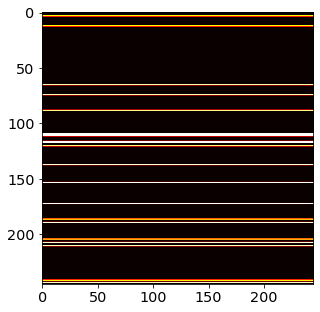

In [80]:
plt.imshow(superParent, cmap='hot')

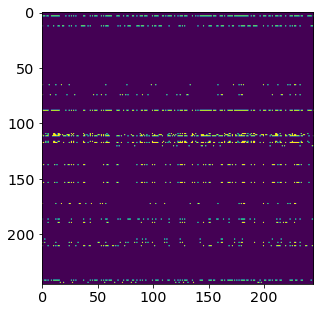

In [81]:
plt.imshow(regulator_gene_matrix)

In [82]:
looseParent = modelSuperParent(superParent, regulator_gene_matrix, 245, 6, 245, 21)
looseParent.compile(optimizer='adam', loss=ignore_noParent_MSE)
looseParent.fit(syntheticDataTrain, syntheticDataTrain, epochs=240, verbose = 0)

In [83]:
ignore_noParent_MSE(testCandidate, k := looseParent.predict(testCandidate)) #used to be 5.144 on old ignore parent

1/1 [==============================] - 0s 104ms/step


<tf.Tensor: shape=(), dtype=float32, numpy=0.0074187587>

In [84]:
u = np.reshape(k, (24,245))
u = pd.DataFrame(u)
u.head()

,0,1,2,3,4,5,6,7,8,9,...,235,236,237,238,239,240,241,242,243,244
0,0.0,0.0,0.0,-0.037663,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.040267,0.0,-0.085648,0.0
1,0.0,0.0,0.0,0.060926,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.155146,0.0,-0.069249,0.0
2,0.0,0.0,0.0,0.230463,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.276776,0.0,-0.002910,0.0
3,0.0,0.0,0.0,0.291149,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.402609,0.0,-0.011413,0.0
4,0.0,0.0,0.0,0.437968,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.539359,0.0,-0.004119,0.0


In [85]:
u = np.reshape(testCandidate, (24,245))
u = pd.DataFrame(u)
u.head()

,0,1,2,3,4,5,6,7,8,9,...,235,236,237,238,239,240,241,242,243,244
0,0.0,0.0,0.0,-0.034413,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.109721,0.0,-0.227669,0.0
1,0.0,0.0,0.0,0.096811,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.163045,0.0,0.065389,0.0
2,0.0,0.0,0.0,0.147692,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.315729,0.0,-0.014181,0.0
3,0.0,0.0,0.0,0.359675,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.503087,0.0,0.039655,0.0
4,0.0,0.0,0.0,0.403032,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.570803,0.0,-0.041109,0.0


In [86]:
# avgMSE = np.average(lossMatrix, axis = 0)
# plt.plot(np.arange(2,33,2), avgMSE);

# DenseNetAutoEncoder

In [87]:
'''
a second copy of the layers which will be modified to be a denseNET auto encoder
'''
#TODO: fix call to map to -1?
class DenseEncoderLinear2(tf.keras.layers.Layer): #TODO: Fix the decoder to -1
    def __init__(self, rgm, oldrgm, input_dim=32, units=32):
        super(DenseEncoderLinear2, self).__init__()
        self.rgm = rgm
        self.oldrgm = oldrgm
        
        def init_weights(shape, dtype="float32"):

            w_init = tf.random_normal_initializer()(shape=shape, dtype=dtype) * tf.convert_to_tensor(self.oldrgm, dtype=dtype)

            return w_init
        

        self.w = tf.Variable(
            initial_value=init_weights(shape=(input_dim, units), dtype="float32"),
            trainable=True,
        )

    def call(self, inputs):
        X = inputs
        return tf.matmul(X, tf.multiply(self.rgm, self.w))
    #tf.matmul(inputs, self.w)

    def get_config(self):
        config = super().get_config()
        config.update({
            "rgm": self.rgm,
            "oldrgm": self.oldrgm,
            'input_dim': 32,
            'units' : 32
        })

class DenseDecoderLinear2(tf.keras.layers.Layer):
    def __init__(self, rgm, oldrgm, input_dim=32, units=32):
        super(DenseDecoderLinear2, self).__init__()
        self.rgm = rgm
        self.oldrgm = oldrgm

        def init_weights(shape, dtype="float32"):

            w_init = tf.random_normal_initializer()(shape=shape, dtype=dtype) * tf.transpose(tf.convert_to_tensor(self.oldrgm, dtype=dtype))

            return w_init

        self.w = tf.Variable(
            initial_value=init_weights(shape=(input_dim, units), dtype="float32"),
            trainable=True,
        )

    def call(self, inputs):
        X = inputs
        #return tf.matmul(X, tf.multiply((self.rgm), self.w))
        return tf.matmul(X, tf.multiply(tf.transpose(self.rgm), self.w)) #used to have a transpose
        #return tf.matmul(inputs, self.w)

    def get_config(self):
        config = super().get_config()
        config.update({
            "rgm": self.rgm,
            "oldrgm": self.oldrgm,
            'input_dim': 32,
            'units' : 32
        })
        

def denseencoder2(parent_child_biological_association, inp, num_hidden_units=21):
    '''
    Encoder structure
    '''
    '''
    The data is time-series. Therefore, CNN to learn the temporal relationship between 
    the intensities for each gene.
    '''
    en_conv = Conv1D(490, 3, activation = "tanh")(parent_child_biological_association) # 6*245
    en_dense = Flatten()(en_conv)
    inp = Flatten()(inp)
    #print(en_dense.shape, inp.shape)
    d = Concatenate()([en_dense, inp]) #dense layer
    o_d = Dense(1024, activation = 'tanh')(d) #added a layer
    c = Concatenate()([o_d, d]) #TOTALY NEW LAYER
    en_dense = Dense(128, activation = 'tanh')(c) #TOTALY NEW LAYER
    
    phenotype = Dense(num_hidden_units, activation="tanh")(d)
    return phenotype

def densedecoder2(X, num_protein_gene, time_steps):
    '''
    Decoder structure
    '''
    de_dense = Dense(784, activation = 'tanh')(X)
    de_dense = Dense(512, activation = 'tanh')(de_dense) #TOTALY NEW LAYER
    de_dense = Dense(256, activation = 'tanh')(de_dense) #added a layer
    de_dense = Reshape((1, 256))(de_dense) #tf.reshape(de_dense, (self.batch_size,1,128))
    de_deconv = Conv1DTranspose(num_protein_gene, time_steps, activation = "tanh")(de_dense) #used to be transpose
    #de_deconv = Conv1D(num_protein_gene, time_steps, activation = "relu")(de_dense) 
    # gene_reconstruction = self.decoder_biological_operation(de_deconv)
    return de_deconv

def modelDense2(rgm, oldrgm, num_protein_gene, time_steps, num_kinase_regulators, num_hidden_units = 21):
    inp = Input(shape=(time_steps, num_kinase_regulators))
    x = DenseEncoderLinear2(rgm, oldrgm, 245, 245)(inp)
    #x = EncoderLinear2(x)
    enc = denseencoder2(x, inp, num_hidden_units)
    dec = densedecoder2(enc, num_protein_gene, time_steps)
    out = DenseDecoderLinear2(rgm, oldrgm, 245, 245)(dec)

    _model = tf.keras.Model(inputs=inp, outputs=out)

    return _model

In [88]:
dense = modelDense2(superParent, regulator_gene_matrix, 245, 6, 245, 21)
dense.compile(optimizer='adam', loss=ignore_noParent_MSE)
dense.fit(genes_intensities_normalized, genes_intensities_normalized, validation_data=(experiment1, experiment1), epochs=1000,  verbose=1)

test = dense(testCandidate) #, verbose = 0)


Epoch 1/1000
1/1 [==============================] - 2s 2s/step - loss: 0.7387 - val_loss: 0.2919
Epoch 2/1000
1/1 [==============================] - 0s 26ms/step - loss: 0.6727 - val_loss: 0.2454
Epoch 3/1000
1/1 [==============================] - 0s 26ms/step - loss: 0.6215 - val_loss: 0.1997
Epoch 4/1000
1/1 [==============================] - 0s 26ms/step - loss: 0.3266 - val_loss: 0.1710
Epoch 5/1000
1/1 [==============================] - 0s 25ms/step - loss: 0.2406 - val_loss: 0.1352
Epoch 6/1000
1/1 [==============================] - 0s 24ms/step - loss: 0.2628 - val_loss: 0.1246
Epoch 7/1000
1/1 [==============================] - 0s 26ms/step - loss: 0.2191 - val_loss: 0.1343
Epoch 8/1000
1/1 [==============================] - 0s 25ms/step - loss: 0.1760 - val_loss: 0.1416
Epoch 9/1000
1/1 [==============================] - 0s 25ms/step - loss: 0.0982 - val_loss: 0.1260
Epoch 10/1000
1/1 [==============================] - 0s 24ms/step - loss: 0.0870 - val_loss: 0.2059
Epoch 11/10

In [89]:
loss = ignore_noParent_MSE(testCandidate, test)
loss

<tf.Tensor: shape=(), dtype=float32, numpy=0.0447696>

In [90]:
np.max(dense.get_weights()[0])

0.15989707

In [91]:
# 'Accent', 'Accent_r', 'Blues', 'Blues_r', 'BrBG', 'BrBG_r', 'BuGn', 'BuGn_r', 'BuPu',
#  'BuPu_r', 'CMRmap', 'CMRmap_r', 'Dark2', 'Dark2_r', 'GnBu', 'GnBu_r', 'Greens', 
#  'Greens_r', 'Greys', 'Greys_r', 'OrRd', 'OrRd_r', 'Oranges', 'Oranges_r', 'PRGn',
#   'PRGn_r', 'Paired', 'Paired_r', 'Pastel1', 'Pastel1_r', 'Pastel2', 'Pastel2_r', 'PiYG', 
#   'PiYG_r', 'PuBu', 'PuBuGn', 'PuBuGn_r', 'PuBu_r', 'PuOr', 'PuOr_r', 'PuRd', 'PuRd_r', 'Purples', 
#   'Purples_r', 'RdBu', 'RdBu_r', 'RdGy', 'RdGy_r', 'RdPu', 'RdPu_r', 'RdYlBu', 'RdYlBu_r', 'RdYlGn', 
#   'RdYlGn_r', 'Reds', 'Reds_r', 'Set1', 'Set1_r', 'Set2', 'Set2_r', 'Set3', 'Set3_r', 'Spectral', 
#   'Spectral_r', 'Wistia', 'Wistia_r', 'YlGn', 'YlGnBu', 'YlGnBu_r', 'YlGn_r', 'YlOrBr', 'YlOrBr_r', 
#   'YlOrRd', 'YlOrRd_r', 'afmhot', 'afmhot_r', 'autumn', 'autumn_r', 'binary', 'binary_r', 'bone', 'bone_r', 
#   'brg', 'brg_r', 'bwr', 'bwr_r', 'cividis', 'cividis_r', 'cool', 'cool_r', 'coolwarm', 'coolwarm_r', 'copper',
#    'copper_r', 'cubehelix', 'cubehelix_r', 'flag', 'flag_r', 'gist_earth', 'gist_earth_r', 'gist_gray', 
#    'gist_gray_r', 'gist_heat', 'gist_heat_r', 'gist_ncar', 'gist_ncar_r', 'gist_rainbow', 'gist_rainbow_r',
#     'gist_stern', 'gist_stern_r', 'gist_yarg', 'gist_yarg_r', 'gnuplot', 'gnuplot2', 'gnuplot2_r', 
#     'gnuplot_r', 'gray', 'gray_r', 'hot', 'hot_r', 'hsv', 'hsv_r', 'inferno', 'inferno_r', 'jet', 
#     'jet_r', 'magma', 'magma_r', 'nipy_spectral', 'nipy_spectral_r', 'ocean', 'ocean_r', 'pink',
#      'pink_r', 'plasma', 'plasma_r', 'prism', 'prism_r', 'rainbow', 'rainbow_r', 'seismic', 'seismic_r',
#       'spring', 'spring_r', 'summer', 'summer_r', 'tab10', 'tab10_r', 'tab20', 'tab20_r', 'tab20b',
#        'tab20b_r', 'tab20c', 'tab20c_r', 'terrain', 'terrain_r', 'turbo', 'turbo_r', 'twilight', 
#        'twilight_r', 'twilight_shifted', 'twilight_shifted_r', 'viridis', 'viridis_r', 'winter', 'winter_r'

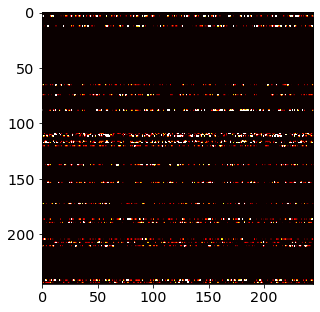

In [92]:
plt.imshow(dense.get_weights()[0], cmap = "hot", vmin=0,vmax=0.01);

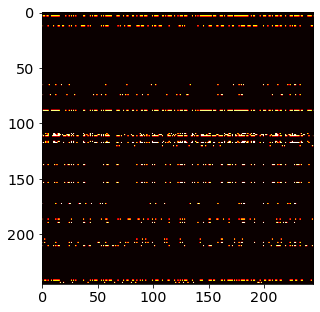

In [93]:
plt.imshow(regulator_gene_matrix, cmap='hot', vmin=0, vmax=1)

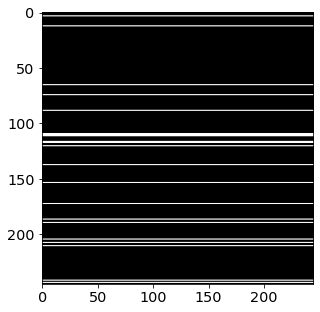

In [94]:
plt.imshow(superParent, cmap='gray', vmin=0, vmax=1);

In [95]:
dense.summary()

Model: "model_3"
__________________________________________________________________________________________________
 Layer (type)                   Output Shape         Param #     Connected to                     
 input_4 (InputLayer)           [(None, 6, 245)]     0           []                               
                                                                                                  
 dense_encoder_linear2 (DenseEn  (None, 6, 245)      60025       ['input_4[0][0]']                
 coderLinear2)                                                                                    
                                                                                                  
 conv1d_3 (Conv1D)              (None, 4, 490)       360640      ['dense_encoder_linear2[0][0]']  
                                                                                                  
 flatten_3 (Flatten)            (None, 1960)         0           ['conv1d_3[0][0]']         

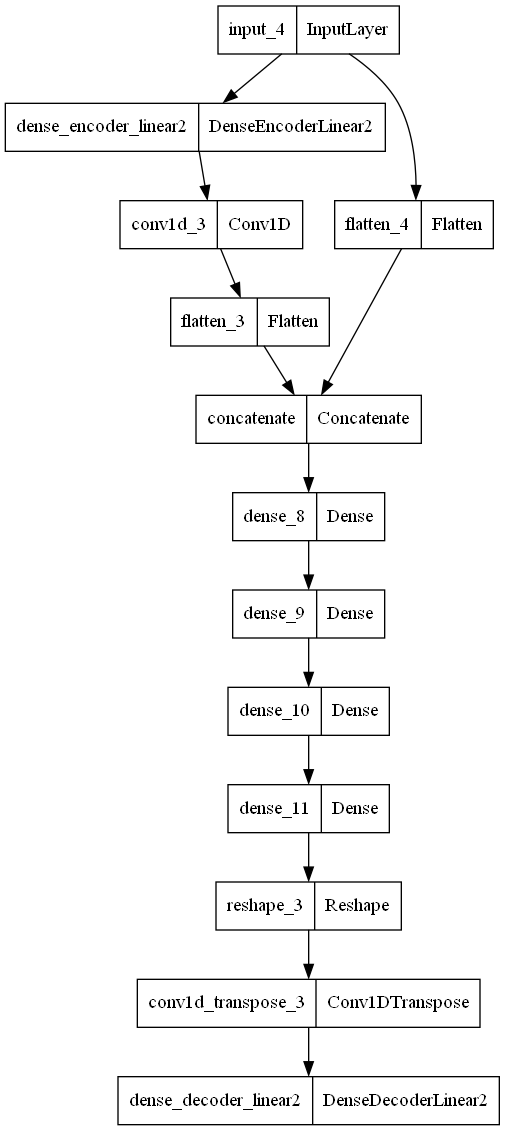

In [96]:
tf.keras.utils.plot_model(dense)

# Latent Space Size Experiment

In [97]:
N = 200
hidden = np.arange(2,33, 1) #range(1,32)
lossMatrix = []
for i in tqdm(range(N)):
    
    
    losses = []
    for value in (hidden):
        dense = modelDense2(superParent, regulator_gene_matrix, 245, 6, 245, value)
        dense.compile(optimizer='adam', loss=ignore_noParent_MSE)
        dense.fit(genes_intensities_normalized, genes_intensities_normalized, epochs=120,  verbose=0)

        test = dense(testCandidate) #, verbose = 0)
        loss = ignore_noParent_MSE(testCandidate, test)
        losses.append(loss)
        tf.keras.backend.clear_session()
    lossMatrix.append(losses)
    
lossMatrix = np.array(lossMatrix)
#run 100 times 

  0%|          | 0/200 [00:32<?, ?it/s]


KeyboardInterrupt: 

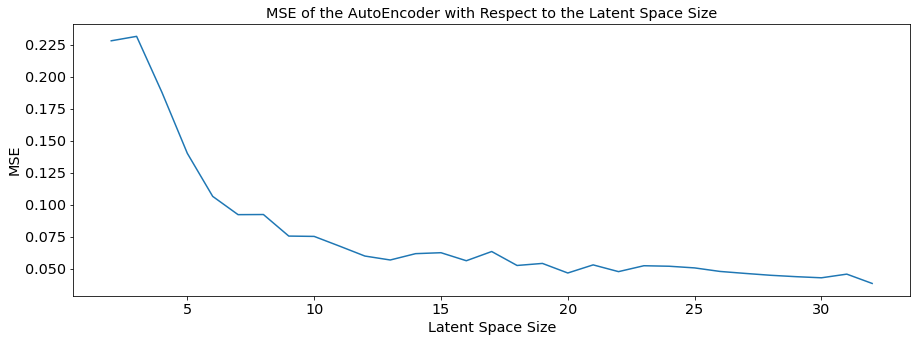

In [ ]:
avgMSE = np.average(lossMatrix, axis = 0)
plt.plot(hidden, avgMSE);
plt.xlabel("Latent Space Size");
plt.ylabel("MSE");
plt.title("MSE of the AutoEncoder with Respect to the Latent Space Size");

In [ ]:
lm = pd.DataFrame(lossMatrix)
lm.to_csv("lossmatrix4lisaN400.csv")

In [ ]:
temp = pd.read_csv("lossmatrix4lisa.csv").to_numpy()
print(temp.shape)
avgMSE = np.average(lossMatrix, axis=0)

(40, 32)


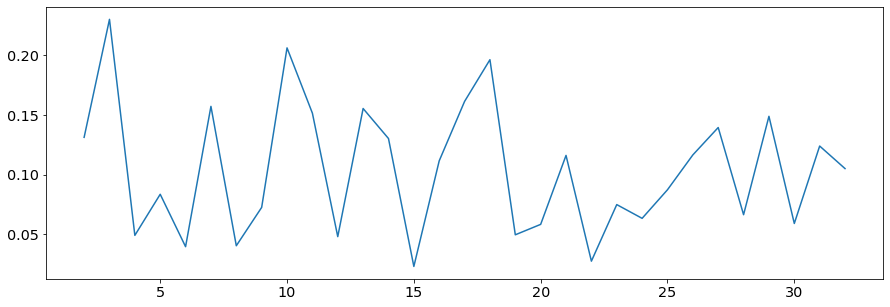

In [ ]:
plt.plot(hidden, avgMSE)

# Lazy Kernels

In [ ]:
parent_idx

array([  3,  12,  65,  74,  88, 109, 110, 111, 116, 117, 120, 137, 153,
       172, 186, 189, 204, 207, 210, 241, 243])

In [ ]:
def do_lazy_train(epochs=60, hidden = 32):
    ep = epochs
    hidden = [hidden,] #range(1,32)
    lossMatrix = []
    lazy_weights = []
    dense = modelDense2(superParent, regulator_gene_matrix, 245, 6, 245, num_hidden_units=32)
    dense.compile(optimizer='adam', loss=ignore_noParent_MSE)

    #for i in tqdm(range(ep)):
    for i in range(ep):
        dense.fit(genes_intensities_normalized, genes_intensities_normalized, validation_data=(experiment1, experiment1), epochs=1,  verbose=0)
        lazy_weights.append(dense.get_weights())
        test = dense(testCandidate) #, verbose = 0)
        loss = ignore_noParent_MSE(testCandidate, test)
        lossMatrix.append(loss)
        
    lossMatrix = np.array(lossMatrix)
    lazy_weights = np.array(lazy_weights)

    return lossMatrix, lazy_weights

In [ ]:
#https://proceedings.mlr.press/v162/rachwan22a/rachwan22a.pdf Winning the Lottery Ticket Ahead of Time:
def lazyKernelRegime(w, parent_idx=parent_idx):

    firstLayer = []
    for i in range(len(w)):
        firstLayer.append(w[i][0][parent_idx])

    fL = np.array(firstLayer)    
    d0 = np.square(fL[1] - fL[0])
    kernelChange = []
    for i in range(1,len(fL)):
        dt = np.square(fL[i] - fL[0])
        dt_minus1 = np.square(fL[i-1] - fL[0])   
        d = np.abs(dt - dt_minus1)/d0                        #eq 11 from the paper
        kernelChange.append(d)
    
    kernelChange = np.moveaxis(kernelChange, 0, 2)
    # plt.plot(kernelChange[0][0]);
    # plt.title("$|\Delta W|$ vs Epoch")
    # plt.xlabel("Epoch")
    # plt.ylabel("$|\Delta W|$")

    return np.array(  kernelChange)

In [ ]:
def compute_distrib(change, t = .05, raw = False): #raw means return the unshaped indicies. 
    stop = []

    for parent in range(len(change)):
        for child in range(len(change[0])):
            try:
                stop.append(np.min(np.argwhere(change[parent][child] < t)))
            except ValueError:
                stop.append(len(change))
                # print(parent, child)
                # plt.plot(change[parent][child])
                # assert(False)
    # print(change.shape)
    # assert(False)
    
    stop = np.array(stop).flatten()
    # print(stop.shape)
    var = np.std(stop)
    # print(var)
    # assert(False)
    mean = np.average(stop)
    top_parents = np.argwhere(stop > mean + 2*var) #get the parents which take more than 2 stds to stop training
    top_parent_child = []
    for tp in top_parents:
        top_parent_child.append(np.unravel_index(tp, shape = (NUM_PARENTS, NUM_TARGETS)))

    if raw == False:
        plt.hist(stop)
        plt.xlabel("Epoch where regulator-target-weight began changing by at most "+ str(t));
        plt.ylabel("Number of parent-child-weights");
        plt.title("Histogram of weight stops");
        print("average stop: ", mean);

    if raw == True:
        return np.array(top_parents)

    return np.array(top_parent_child)

In [ ]:
def lazyKernels(N=100):

    candidates = []
    final_w = []
    for i in tqdm(range(N)):
        lm, lazy_weights = do_lazy_train(epochs=80)
        change = lazyKernelRegime(lazy_weights)
        top_pr = np.squeeze(compute_distrib(change, t = 0.05, raw=True))
        candidates.append(top_pr)
        final_w.append(lazy_weights[-1])
    
    final_w = np.array(final_w)
    firstLayer = []
    for i in range(len(final_w)):
        firstLayer.append(np.abs(final_w[i][0][parent_idx]))
    fw = np.array(firstLayer)
    #print(fw.shape)
    fw_avg = np.average(fw, axis = 0)
    #print(fw_avg.shape)
    
    candidates = np.hstack(candidates)
    candidates = candidates.reshape(candidates.size)
    #print(candidates.shape)

    plt.hist(candidates, bins=np.arange(0, NUM_PARENTS*NUM_TARGETS))
    plt.title("Parent-Child Regulator Histogram")
    plt.xlabel("Parent-Child Weight")
    plt.ylabel("Num-Times parent-child relationship trained for top 5% of time")
    return candidates, fw_avg



100%|██████████| 100/100 [19:29<00:00, 11.70s/it]


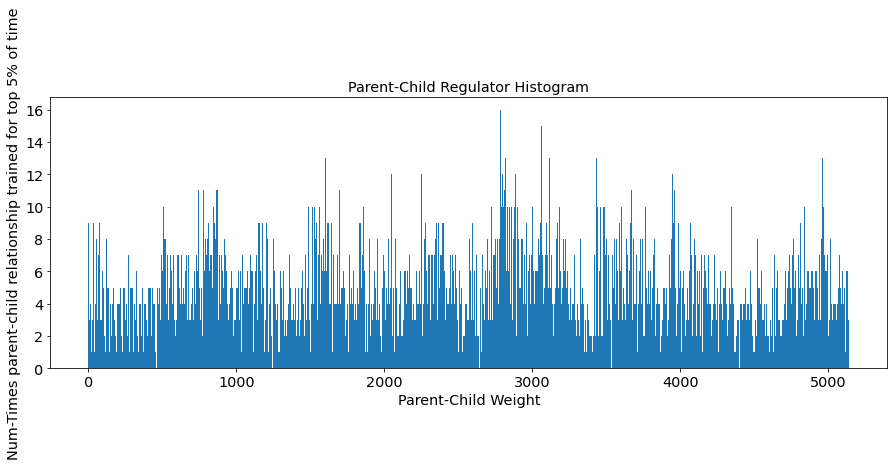

In [ ]:
can, mag = lazyKernels()

In [ ]:
can.shape

(25314,)

In [ ]:
pdf, bins = np.histogram(can, np.arange(NUM_PARENTS*NUM_TARGETS))
pdf

array([ 9,  6,  5, ...,  6,  8, 11], dtype=int64)

In [ ]:
mag.shape

(21, 245)

# Magnitudes After Training

In [ ]:
NUM_PARENTS*NUM_TARGETS

5145

In [ ]:
np.unravel_index(5144, shape = (NUM_PARENTS, NUM_TARGETS))

(20, 244)

In [ ]:
def get_top_reg_targets(can, mag):
    
    pdf, bins = np.histogram(can, np.arange(0, NUM_PARENTS*NUM_TARGETS))
    pdf2d = np.zeros(shape = (NUM_PARENTS,NUM_TARGETS))

    for i in bins:
      idx2d = np.unravel_index(i, shape = (NUM_PARENTS, NUM_TARGETS))
      try:
        pdf2d[idx2d] = pdf[i]
      except IndexError:
        print(i, idx2d, len(pdf), len(bins))
    

    importance = np.multiply(pdf2d, mag)
    return importance

In [ ]:
top = get_top_reg_targets(can, mag)

5144 (20, 244) 5144 5145


In [ ]:
top.shape

(21, 245)

In [ ]:
np.max(top)

0.6338352710008621

In [ ]:
top[12][122]

0.6338352710008621

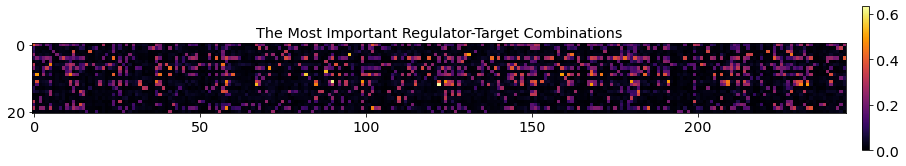

In [ ]:
u = plt.imshow(top, cmap = 'inferno', vmin = 0, vmax = np.max(top));
plt.colorbar(u ,fraction=0.0086, pad=0.02);
plt.title("The Most Important Regulator-Target Combinations");

In [ ]:
topID = np.array(np.unravel_index(np.argsort(top, axis=None), top.shape))
topID = np.flip(topID, axis=1)
topID[0] = parent_idx[topID[0]]
topID = topID.T
topID

array([[ 12,  11,   9, ...,   0,  19,  20],
       [122,  90,  82, ..., 222, 112, 244]], dtype=int64)

In [ ]:
# topR_T = pd.DataFrame(topID)
# topR_T.to_csv("Top_reg_target_decendingOrder_firstColIsRegulator.csv")

In [ ]:
best = np.zeros(21)
for i in range(21):
    best[i] = np.sum(top[i])
best

array([25.06789506, 14.06036284,  9.60177146, 12.89100461, 32.9594341 ,
        9.08954432, 20.41964841, 25.84978009, 10.20538858, 29.59557745,
        6.83530845, 23.80426369, 21.97004492,  7.96760633, 14.96920873,
       10.5033031 ,  7.97299281,  8.80683971, 10.45251573, 20.69876599,
        6.35512698])

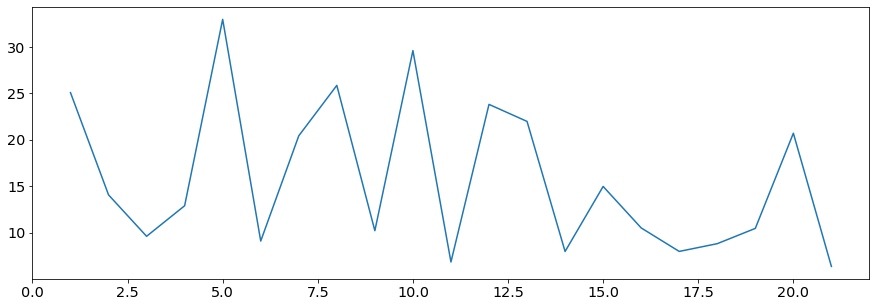

In [ ]:
x = np.arange(1,22, dtype=int)
plt.plot(x, best); 

In [ ]:
idx = np.flip(np.argsort(best))
idx

array([ 4,  9,  7,  0, 11, 12, 19,  6, 14,  1,  3, 15, 18,  8,  2,  5, 17,
       16, 13, 10, 20], dtype=int64)

In [ ]:
parent_idx[idx] 

array([ 88, 117, 111,   3, 137, 153, 241, 110, 186,  12,  74, 189, 210,
       116,  65, 109, 207, 204, 172, 120, 243])

In [ ]:
np.unique(can).size

1074

# Inference on Petal Len

In [ ]:
petal = pd.read_excel(data_path_petal)

In [ ]:
petal_train = petal[petal["Line"] == "WT"]
petal_train = petal_train.drop(columns=['Line', 'ID', "Treatment"])
petal_train.head(12)
petal_train = petal_train.groupby(['Plate']).mean()
petal_train.head()
petal_train = petal_train.to_numpy()
print(petal_train.shape)
scaler1 = StandardScaler()
scaler1.fit(petal_train)
petal_train = scaler1.transform(petal_train)
mm = MinMaxScaler()
mm.fit(petal_train)
petal_train = mm.transform(petal_train)
petal_train

(4, 1)


array([[0.95361071],
       [1.        ],
       [0.        ],
       [0.34194165]])

In [ ]:
petal_test = petal[petal["Line"] != "WT"]
petal_test = petal_test.drop(columns=['Line', 'ID', "Treatment"])
petal_test = petal_test.groupby(['Plate']).mean()
petal_test.head()
petal_test = petal_test.to_numpy()
print(petal_test.shape)
petal_test = scaler1.transform(petal_test)
petal_test = mm.transform(petal_test)
petal_test

(4, 1)


array([[ 0.33225729],
       [-0.11669058],
       [-0.62362506],
       [-0.59851746]])

In [ ]:
experiment1.shape
testCandidate.shape

(4, 6, 245)

In [ ]:
densePredictor = modelDense2(superParent, regulator_gene_matrix, 245, 6, 245, 22)
densePredictor.compile(optimizer='adam', loss=ignore_noParent_MSE)
densePredictor.fit(genes_intensities_normalized, genes_intensities_normalized,validation_data=(experiment1, experiment1),  epochs=100,  verbose=1)
test = densePredictor(testCandidate) #, verbose = 0)
loss = ignore_noParent_MSE(testCandidate, test)
print(loss)

Epoch 1/100
1/1 [==============================] - 2s 2s/step - loss: 0.9032 - val_loss: 0.3153
Epoch 2/100
1/1 [==============================] - 0s 52ms/step - loss: 0.5925 - val_loss: 0.2815
Epoch 3/100
1/1 [==============================] - 0s 107ms/step - loss: 0.5551 - val_loss: 0.2404
Epoch 4/100
1/1 [==============================] - 0s 63ms/step - loss: 0.3848 - val_loss: 0.2257
Epoch 5/100
1/1 [==============================] - 0s 35ms/step - loss: 0.2503 - val_loss: 0.2049
Epoch 6/100
1/1 [==============================] - 0s 26ms/step - loss: 0.1982 - val_loss: 0.1794
Epoch 7/100
1/1 [==============================] - 0s 25ms/step - loss: 0.2028 - val_loss: 0.2715
Epoch 8/100
1/1 [==============================] - 0s 25ms/step - loss: 0.1422 - val_loss: 0.2452
Epoch 9/100
1/1 [==============================] - 0s 24ms/step - loss: 0.1363 - val_loss: 0.1729
Epoch 10/100
1/1 [==============================] - 0s 27ms/step - loss: 0.1243 - val_loss: 0.1603
Epoch 11/100
1/1 [==

In [ ]:
rgm = superParent
time_steps = 6
num_kinase_regulators = 245
num_hidden_units = 22

inp = Input(shape=(time_steps, num_kinase_regulators))
x = DenseEncoderLinear2(rgm, regulator_gene_matrix, 245, 245)(inp)
enc = denseencoder2(x, inp, num_hidden_units)
denseP = tf.keras.Model(inputs=inp, outputs=enc)
#set the weights of the encoder to the weights of auto encoder
dw = densePredictor.get_weights()
enc_w = dw[0:5]
denseP.set_weights(enc_w)
#add a dense layer  because we are ouputing 1 number
l = Dense(32, activation = 'swish', use_bias=True, kernel_regularizer='l1_l2')(denseP.layers[-1].output)
l = Dense(1, activation = 'linear', use_bias = True)(l)
denseP = tf.keras.Model(denseP.inputs, l)
#denseP.summary()

In [ ]:
bp = np.concatenate([experiment1, experiment1, experiment1, experiment1])
bp.shape
#bigexperiment1.shape

(16, 6, 245)

In [ ]:
a = petal_train[0]
b = petal_train[1]
c = petal_train[2]
d = petal_train[3]

petal_train1 = np.array([a,a,a,a, b,b,b,b, c,c,c,c, d,d,d,d]) #does this make sense? we are training network to predict .5
petal_train1.shape

(16, 1)

In [ ]:
denseP.compile(optimizer='adam', loss=tf.keras.losses.MeanSquaredError())
denseP.fit(experiment1, petal_train, epochs=500, verbose = 1)

Epoch 1/500
1/1 [==============================] - 0s 432ms/step - loss: 3.1126
Epoch 2/500
1/1 [==============================] - 0s 7ms/step - loss: 1.7468
Epoch 3/500
1/1 [==============================] - 0s 8ms/step - loss: 1.6966
Epoch 4/500
1/1 [==============================] - 0s 12ms/step - loss: 1.6506
Epoch 5/500
1/1 [==============================] - 0s 6ms/step - loss: 1.5390
Epoch 6/500
1/1 [==============================] - 0s 8ms/step - loss: 1.4849
Epoch 7/500
1/1 [==============================] - 0s 14ms/step - loss: 1.4689
Epoch 8/500
1/1 [==============================] - 0s 13ms/step - loss: 1.4583
Epoch 9/500
1/1 [==============================] - 0s 20ms/step - loss: 1.4479
Epoch 10/500
1/1 [==============================] - 0s 6ms/step - loss: 1.4462
Epoch 11/500
1/1 [==============================] - 0s 16ms/step - loss: 1.4483
Epoch 12/500
1/1 [==============================] - 0s 8ms/step - loss: 1.4479
Epoch 13/500
1/1 [==============================] - 0s

In [ ]:
testCandidate.shape

(4, 6, 245)

In [ ]:
denseP(experiment1) #experiment1 is part of the training set.

<tf.Tensor: shape=(4, 1), dtype=float32, numpy=
array([[0.92966014],
       [0.9766529 ],
       [0.0213808 ],
       [0.3415962 ]], dtype=float32)>

In [ ]:
petal_train

array([[0.95361071],
       [1.        ],
       [0.        ],
       [0.34194165]])

In [ ]:
print(denseP(testCandidate)) #model output

tf.Tensor(
[[0.8693478]
 [0.7939956]
 [0.8643215]
 [0.8332281]], shape=(4, 1), dtype=float32)


In [ ]:
petal_test #true label

array([[ 0.33225729],
       [-0.11669058],
       [-0.62362506],
       [-0.59851746]])

In [ ]:
petal_train

array([[0.95361071],
       [1.        ],
       [0.        ],
       [0.34194165]])

In [ ]:
denseP.evaluate(testCandidate, petal_test) #eval gave 1.3999 before

1/1 [==============================] - 0s 122ms/step - loss: 1.3577


1.3576784133911133

# Junk

In [ ]:
d = np.zeros(shape = (3,6,8))
id = np.unravel_index(3*6*8 - 1, shape = d.shape)
d[id] = 1
plt.imshow(d[2])

In [ ]:
testCandidate[0][ : , parentIndex]

array([[ 0.33262452, -1.        ,  0.72367883,  0.47297269,  0.49418113,
         0.6420384 ,  0.50394946,  0.6847614 ,  0.73492372,  0.41228548,
         0.6689055 ,  0.41653621,  0.46169034,  0.57737494,  0.52793521,
         0.60674787,  0.73796624,  0.59914976,  0.68748152,  0.57264143,
         0.52044106],
       [ 0.31294832,  0.53610921, -1.        ,  0.48029006,  0.52149838,
         0.63579446,  0.47784179,  0.67492956,  0.76559806,  0.48408878,
         0.662256  ,  0.40146986,  0.45550761,  0.67242122,  0.58750564,
         0.5983696 ,  0.73721415,  0.63350546,  0.57812268,  0.62972462,
         0.60348046],
       [ 0.32165319, -1.        ,  0.73791933,  0.47455293,  0.42869982,
         0.62651557,  0.51567709,  0.69742841,  0.71932632,  0.48579505,
         0.7755844 , -1.        ,  0.4297246 ,  0.61820638,  0.56006104,
         0.5661965 ,  0.73307377,  0.54605776,  0.67557687,  0.61726093,
         0.57843435],
       [ 0.36271837,  0.38536492,  0.68728441,  0.45066956

In [ ]:
print(outSyn.shape)
print(testCandidate.shape)
syntheticLoss = ignore_noParent_MSE(np.array([testCandidate[0]]), np.array([outSyn[0]]) )
syntheticLoss

(4, 6, 245)
(4, 6, 245)
tf.Tensor(
[[[ 0.33262452 -1.          0.72367883  0.47297269  0.49418113
    0.6420384   0.50394946  0.6847614   0.73492372  0.41228548
    0.6689055   0.41653621  0.46169034  0.57737494  0.52793521
    0.60674787  0.73796624  0.59914976  0.68748152  0.57264143
    0.52044106]
  [ 0.31294832  0.53610921 -1.          0.48029006  0.52149838
    0.63579446  0.47784179  0.67492956  0.76559806  0.48408878
    0.662256    0.40146986  0.45550761  0.67242122  0.58750564
    0.5983696   0.73721415  0.63350546  0.57812268  0.62972462
    0.60348046]
  [ 0.32165319 -1.          0.73791933  0.47455293  0.42869982
    0.62651557  0.51567709  0.69742841  0.71932632  0.48579505
    0.7755844  -1.          0.4297246   0.61820638  0.56006104
    0.5661965   0.73307377  0.54605776  0.67557687  0.61726093
    0.57843435]
  [ 0.36271837  0.38536492  0.68728441  0.45066956  0.51011139
    0.63238078 -1.          0.66769308  0.72368777  0.51241136
    0.65023452  0.48790294  0.45640

<tf.Tensor: shape=(), dtype=float32, numpy=0.34608406>

In [ ]:
dd

Text(0, 0.5, 'change in weight')

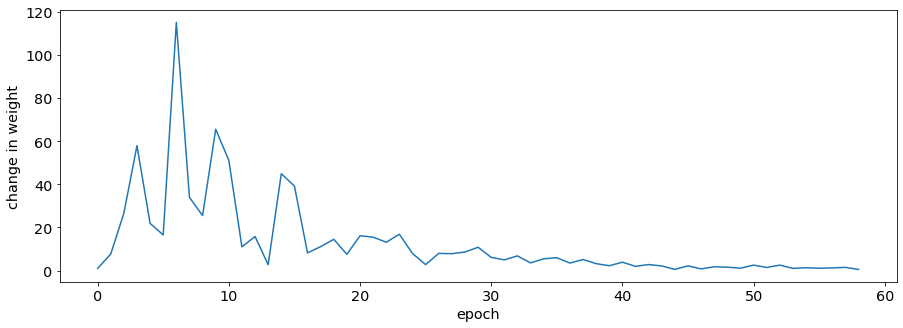

In [ ]:
plt.plot(change[0][22])
plt.xlabel("epoch")
plt.ylabel("change in weight")

Text(0, 0.5, 'MSE')

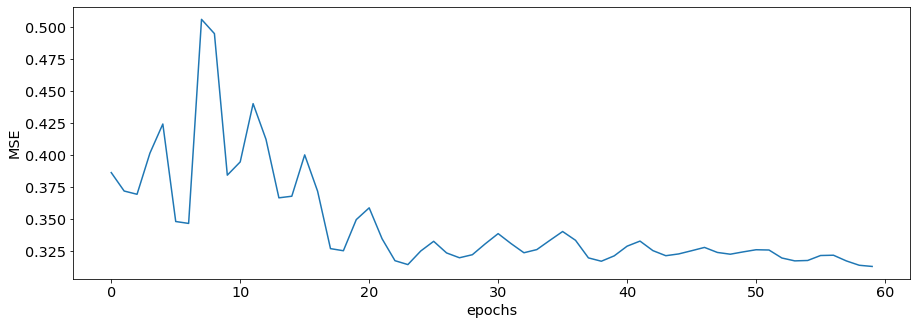

In [ ]:
plt.plot(lossMatrix)
plt.xlabel("epochs")
plt.ylabel("MSE")

In [ ]:
print(change.shape, lossMatrix.shape)

(21, 245, 59) (60,)


(58,)

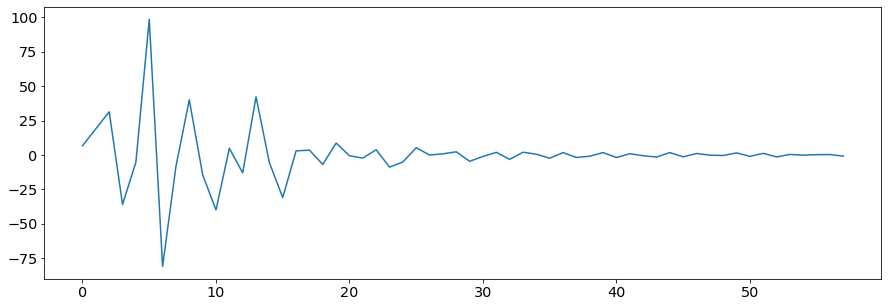

In [ ]:
d = np.diff(change[0][22])
plt.plot(d)
d.shape

In [ ]:
change[0][0].flatten()

array([1.0000000e+00, 6.2267208e+00, 8.4244858e+01, 2.3190759e+02,
       4.6938145e+01, 1.4571043e+01, 3.2468436e+02, 5.2167248e+01,
       1.9098307e+01, 2.3784262e+02, 1.4972844e+02, 9.0305321e+01,
       1.4454961e+01, 1.0191910e+01, 1.4444521e+02, 1.1422652e+02,
       4.4633780e+00, 7.0878799e+01, 1.0034342e+02, 2.4216372e+01,
       4.2676544e+01, 8.8577652e+00, 3.1776845e-02, 7.1697868e+01,
       4.3129757e+01, 1.0543992e+01, 3.4226681e+01, 1.0355385e+01,
       2.6150772e+01, 4.8526745e+00, 8.5592079e+00, 1.5769169e+01,
       5.3766422e+01, 1.8505602e+01, 1.4997946e+01, 3.8863201e+00,
       3.3604797e+01, 2.6563268e+00, 7.2169685e+00, 1.2690077e+01,
       2.8381071e+01, 7.7667198e+00, 8.0884752e+00, 1.2734420e+01,
       1.7506987e+01, 1.4849573e+01, 5.8457313e+00, 1.4414846e+01,
       4.9223903e-01, 1.8104948e+01, 6.3936701e+00, 1.4318429e+01,
       1.2278428e+01, 6.0279346e+00, 1.2717383e+01, 1.9357294e+00,
       6.8698397e+00, 7.1682763e+00, 1.3986886e+01], dtype=flo

In [ ]:
top_pr.shape

(281, 2, 1)

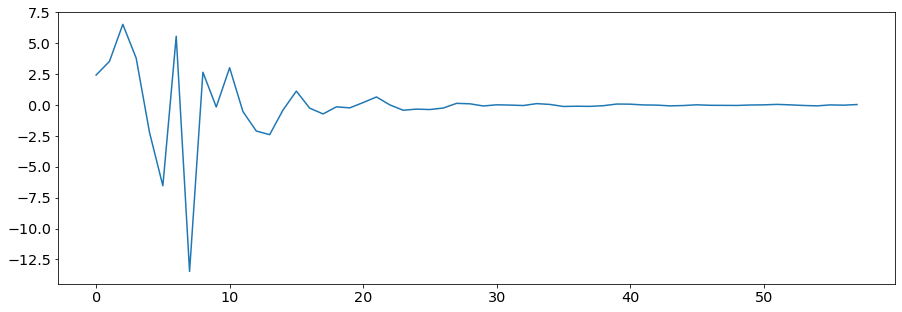

In [ ]:
plt.plot(d[0])

In [ ]:

# def compute_tresh(change, stop = 0.05):
#     diffs = []
#     for parent in range(len(change)):
#         for child in range(len(change[0])):
#             diffs.append(np.diff(change[parent][child]))
#     inflection = []


#     try:
#         for d in diffs:
#             print(np.argwhere(np.abs(d) < stop))
#             inflection.append(np.min(np.argwhere(np.abs(d) < stop))) #return where the second derivative is first 0. 

#     except ValueError:
#         print("Stop value ", stop, " is too high, trying stop = ", stop + 0.05)
#         # s = stop + 0.05
#         # return compute_tresh(change, stop = s)
        

#     return np.average(inflection)
        
# d = compute_tresh(change)
# d.shape

In [ ]:
#np.save("mse3.npy", avgMSE) #mse2/3 is with -1 fix

In [ ]:
#https://www.sciencedirect.com/science/article/pii/S0925231220314570?casa_token=lcEJANqO0JwAAAAA:uL3DGUZctPUZz_sPz1K1i2klMtb83TyKnc9CI3_N-uSOaM7VHL8GhM0jCGYfo25NmpDQQ9Cvlw

In [ ]:
rshp = Flatten()(looseParent.layers[-1].output)

modelTemp = tf.keras.Model(inputs=looseParent.input, outputs = [rshp])
modelTemp.summary()
type(modelTemp)
explainer = shap.DeepExplainer(modelTemp, syntheticDataTrain)
#shap.explainers._deep.deep_tf.op_handlers["AddV2"] = shap.explainers._deep.deep_tf.passthrough #this solves the "shap_ADDV2" problem but another one will appear
#shap.explainers._deep.deep_tf.op_handlers["FusedBatchNormV3"] = shap.explainers._deep.deep_tf.passthrough #this solves the next problem which allows you to run the DeepExplainer.

shap_values = explainer.shap_values(testCandidate[0:1])
def f(x):
    return modelTemp.predict(x)

print(f(testCandidate))
explainer = shap.KernelExplainer(f , testCandidate[0:1], link="logit") #svm.predict_proba, X_train, link="logit")
shap_values = explainer.shap_values(testCandidate[0:1], nsamples=100)
def map2layer(x, layer):
    feed_dict = dict(zip([model.layers[0].input], [preprocess_input(x.copy())]))
    return K.get_session().run(model.layers[layer].input, feed_dict)
e = shap.GradientExplainer(
    (model.layers[7].input, model.layers[-1].output),
    map2layer(X, 7),
    local_smoothing=0 # std dev of smoothing noise
)
from keras.applications.vgg16 import VGG16
from keras.applications.vgg16 import preprocess_input
import keras.backend as K
import numpy as np
import json
import shap

# load pre-trained model and choose two images to explain
model = VGG16(weights='imagenet', include_top=True)
X,y = shap.datasets.imagenet50()
to_explain = X[[39,41]]

# load the ImageNet class names
url = "https://s3.amazonaws.com/deep-learning-models/image-models/imagenet_class_index.json"
fname = shap.datasets.cache(url)
with open(fname) as f:
    class_names = json.load(f)

# explain how the input to the 7th layer of the model explains the top two classes
def map2layer(x, layer):
    feed_dict = dict(zip([model.layers[0].input], [preprocess_input(x.copy())]))
    return K.get_session().run(model.layers[layer].input, feed_dict)
e = shap.GradientExplainer(
    (model.layers[7].input, model.layers[-1].output),
    map2layer(X, 7),
    local_smoothing=0 # std dev of smoothing noise
)
shap_values,indexes = e.shap_values(map2layer(to_explain, 7), ranked_outputs=2)

# get the names for the classes
index_names = np.vectorize(lambda x: class_names[str(x)][1])(indexes)

# plot the explanations
shap.image_plot(shap_values, to_explain, index_names)